In [1]:
## Script for plotting results of the production localizer experiment in EvLab
# Figure 2, language network fROI responses to the conditions of language and production localizers
# Figure 3, MD network fROI responses to the conditions of MD and production localizers

# Preliminaries

In [41]:
#dependencies
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse, Circle
import pandas as pd
import numpy as np
import statistics
import math
import nibabel as nib
from nilearn import plotting

sns.set(style="ticks", font_scale=3.5)

In [39]:
#define helper filter functions

#function that filters a dataframe by specified values in a specified column of the dataframe
# example: dataframe containing columns subject_id, fROI, condition, effect_size
# calling filter_X(data, ['cond1','cond2'], 'condition') will return the dataframe with only the rows
# that have cond1 or cond2 as the condition
def filter_X(data, targets, name_in_data):
    if isinstance(targets, list): 
        filter = 0
        for target in targets:
            filter = filter | (data[name_in_data] == target)
        return (data[filter])
    else:
        raise TypeError("targets must be a list")

# function that filters a dataframe by the specified conditions in the Effect column for each expt (use filter_X for a 
# more general purpose filter function -- you can specify the column name to filter on there)
def filter_conditions(data, conditions):
    if(isinstance(conditions,dict)):
        tmp = []
        for expt in conditions:
            tmp = tmp + conditions[expt]
        
        conditions = np.unique(tmp)
        filter = 0
        for cond in conditions:
            filter = filter | (data.Effect == cond)
        return (data[filter])
    else:
        raise Exception('conditions should be a dictionary specifying the conditions to be retained for each expt')

# function that modifies experiment names -- this was very specific to the production paper, but could 
# potentially be used for other things. consolidated_expt is an experiment that is present in all of the 
# different experiments, for example, langloc. experiment_names is a list of experiments currently in the dataframe 
# and new_exp_names is a list of new names (parallel with experiment_names) -- critical_tasks is more labels 
# for the exp_names (kind of specific to production paper)
def modify_experiment_names(data, consolidated_expt, experiment_names, new_exp_names, critical_tasks):
    modified_data = data[0:0]
    for ind,exp in enumerate(experiment_names):
        if(consolidated_expt!=None):
            if(exp !=consolidated_expt):
                selected_data = data[(data.Expt==exp) & (data.CriticalTask==critical_tasks[ind])].copy()
            else:
                selected_data = data[(data.CriticalTask==critical_tasks[ind])].copy()
        else:
            selected_data = data[(data.CriticalTask==critical_tasks[ind])].copy()
            
        
        selected_data.loc[:,'Expt'] = new_exp_names[ind]
        modified_data = pd.concat([modified_data, selected_data])
    return(modified_data)

#wrapper function to filter and prep data for plotting figures for production paper
def prep_data(data, consolidated_expt, networks, hemispheres, ROIs, conditions, critical_tasks, experiment_names, new_exp_names):
    prepped_data = data
    prepped_data = filter_X(prepped_data, networks, 'Network')
    prepped_data = filter_X(prepped_data, hemispheres,'Hemisphere')
    prepped_data = filter_X(prepped_data, ROIs,'ROI')
    prepped_data = filter_conditions(prepped_data, conditions)
    
    prepped_data = modify_experiment_names(prepped_data, consolidated_expt, experiment_names, new_exp_names, critical_tasks)
    
    return (prepped_data)


#helper functions for plotting

#this function adds the expanded labels with n count below each group of bars corresponding to an experiment
def add_extended_labels(ax,data,network,label_dict,expt_order,font_size, x_pos):
    expts = expt_order
    num_expts = len(expts)
    
    n_dict = dict()
    for expt in expts:
        n_dict[expt] = len(np.unique(data[data.Expt==expt]['Subject']))
          
    label_y = -0.15 #-0.2
#     n_y = label_y-0.04
    
    if((network=="lowlevel_speaking") | (network=="lowlevel_typing")):
        label_y = -0.2
#         n_y = label_y-0.06
    
    #the x coords of this transformation are data, and the y coord are axes, so we can plot below the axes
    #https://matplotlib.org/tutorials/advanced/transforms_tutorial.html
    #trans = ax.get_xaxis_transform()
    
    for i in range(num_expts):
        x = x_pos[i]
#         ax.annotate(text="n = " + str(n_dict[expts[i]]),
#                     xy=(x,n_y), xycoords=('data','axes fraction'),
#                     horizontalalignment='center', verticalalignment='bottom',
#                     fontsize=font_size )
        text = f"n={n_dict[expts[i]]} {label_dict[expts[i]]}" if not network.startswith("lowlevel") else label_dict[expts[i]]
        ax.annotate(text=text,
                     xy=(x,label_y), xycoords=('data','axes fraction'),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=font_size)
               

# this function adds experiment specific icons underneath groups of bars corresponding to different experiments
def add_icons(ax,label_dict,expts, x_pos, shift):
    #read in images for plotting
    mouth_img = plt.imread('../images/mouth.png')
    keyboard_img = plt.imread('../images/keyboard.png')
    
    #make room for icons
    old_bottom = ax.get_ylim()[0]
    new_bottom = old_bottom-0.7
    ax.set_ylim(bottom=new_bottom)
    
    y = (new_bottom-old_bottom)/2
    num_expts = len(expts)
    for i in range(num_expts):
        label = label_dict[expts[i]]
        if(label!=''):
            x = x_pos[i]
            if("typed" in label):
                im = OffsetImage(keyboard_img,zoom=0.2)
            else:
                im = OffsetImage(mouth_img,zoom=0.45)
            ab=AnnotationBbox(im, (x+shift[i],y), xycoords='data',frameon=False, box_alignment=(0.5,0.5)) #(0.0,0.5))
            ax.add_artist(ab)

# this function adds an image to the figure in roughly the top right (changes according to which figure it is)             
def add_brain_image(ax,image_file, main_brain, network):
    brain_img = plt.imread(image_file)
    if(main_brain):
        im = OffsetImage(brain_img,zoom=0.8)
        y = 0.7
    else:
        im = OffsetImage(brain_img,zoom=0.6)
        y = 0.75
        
    legend = ax.get_legend()
        
    #different x position depending on whether there is a legend on plot
    if(legend==None):
        x = 0.6
    else:
        x = 0.55
        
#     if(network =="lang"):
#         x = x - 0.08
        
    if(network =="MD"):
        im = OffsetImage(brain_img,zoom=0.31)
        y = y + 0.1
        x = x - 0.1
        
    if(network == "lowlevel_speaking"):
        x = x
        y = y
        
    if(network == "lowlevel_typing"):
        x = x - 0.53
        y = y - 0.06

    
    ab=AnnotationBbox(im, (x,y), xycoords='axes fraction', frameon=False, box_alignment=(0.0,0.5))
    ax.add_artist(ab)

#this function generates a list of means and standard errors in a given expt order from the specified conditions in a dataset
def generate_bar_data(data,expt_order,conditions):
    
    if not isinstance(conditions,dict):
        raise TypeError("conditions must be a dictionary specifying the conditions for each expt")
        
    bar_means_list = []
    bar_errors_list = []
    for expt in expt_order:
        bar_means = []
        bar_errors = []
        for condition in conditions[expt]:
            current_data = data[(data.Expt==expt)&(data.Effect==condition)]["EffectSize"]
#             print(condition)
#             print(current_data)
#             print(expt)
            n = len(current_data)
            mean = statistics.mean(current_data)
            SEM = statistics.stdev(current_data)/math.sqrt(n)
            
            bar_means.append(mean)
            bar_errors.append(SEM)
            
        bar_means_list.append(bar_means)
        bar_errors_list.append(bar_errors)
    
    return (bar_means_list, bar_errors_list)
            


In [3]:
#function to make a figure from given data -- assumes individual level data
def plot_data(ax,data, data_title,network, expt_order, conditions, xlim=None,ylim=None,ylabel=True,main_brain=False,brain_image="",plot_legend=False,plot_labels=False,plot_icons=False):
    
    SMALL_SIZE = 40
    MEDIUM_SIZE = 50
    BIGGER_SIZE = 60

#     plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
#     plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
#     plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
#     plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
#     plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
#     plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
#     plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#     plt.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

    #for plotting
    color_dict = {'SProd':'firebrick',
                 'WProd':'lightcoral',
                 'NProd':'mistyrose',
                 'SComp':'steelblue',
                 'WComp':'lightblue',
                 'VisEvSem':'seagreen',
                 'Hard WM':'dimgrey',
                 'Easy WM':'lightgrey',
                 'Sentences':'dimgrey',
                 'Nonwords':'lightgrey'}
    tmp = []
    for expt in conditions:
        tmp = tmp + conditions[expt]
    all_conditions = tmp #extract all conditions
    
    conditions_for_legend = pd.unique(all_conditions)
    
    num_bars = len(all_conditions)
    
    colors_to_plot = [color_dict[x] for x in all_conditions]
    colors_to_plot.reverse() #so we can pop the colors off while plotting

    bar_alpha = 1
    make_bar_smaller = 2
    bar_width = (1/num_bars)/make_bar_smaller
    edgecolor = "black"
    linewidth = 4
    capsize = 0
    
    bar_means_all_expts, bar_errors_all_expts = generate_bar_data(data,expt_order,conditions)
    
    sliding_x_pos = 0
    space_between_expts = bar_width*1.5
    
    #will use these lists to put labels on x-axis in correct positions
    first_x_pos = [] #list to keep track of the x pos of the first condition in each expt
    last_x_pos = [] #list to keep track of the x pos of the last condition in each expt
    
    #outer loop goes through the different experiments, inner loop goes through each condition of each experiment
    # and plots each condition as a bar, sliding_x_pos keeps track of the x position of the current bar
    for expt_index,(expt_means,expt_errors) in enumerate(zip(bar_means_all_expts,bar_errors_all_expts)):
        for cond_index,(mean,error) in enumerate(zip(expt_means,expt_errors)):
            if(cond_index==0):
                first_x_pos.append(sliding_x_pos)
            ax.bar(x = sliding_x_pos,
                   height=mean,
                   width=bar_width,
                   color=colors_to_plot.pop(),
                   yerr=error, 
                   error_kw={'linewidth':linewidth, 'capsize':capsize, 'capthick':linewidth},
                   alpha=bar_alpha,
                   edgecolor = edgecolor,
                   linewidth=linewidth
                  )
            sliding_x_pos = sliding_x_pos + bar_width
        last_x_pos.append(sliding_x_pos) 
        sliding_x_pos = sliding_x_pos + space_between_expts

    #save the x_label_pos of each group of experiments (use this for extended labels and icons later)
    # the 2.7 is a constant that I had to manually play around with get the spacing right
#     x_label_pos = [(last_x_pos[i]-first_x_pos[i])/2.7 + first_x_pos[i] for i in range(len(first_x_pos))]
#     left_shift = bar_width/2
    x_label_pos = [first_x_pos[i] + bar_width*len(conditions[expt_order[i]])/2 - bar_width/2 for i in range(len(first_x_pos))]

    ax.set(xticks = x_label_pos,
           xticklabels= expt_order)
    ax.set_title(data_title, fontweight="bold", pad=20)
    if ylabel:
        if not main_brain:
            ax.set_ylabel('% BOLD signal change')
        else:
            ax.set_ylabel('% BOLD signal change', size="large")
    
    if(ylim!=None):
        ax.set(ylim=ylim)
    if(xlim!=None):
        ax.set(xlim=xlim)
        
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4)
    
    legend_handles = [
        mpatches.Patch(color=color_dict[cond], ec=edgecolor, lw=linewidth, label=cond) 
        for cond in conditions_for_legend
    ]

#     legend_fontsize = 'x-small'
    legend_kws = dict(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    #different legend formatting in lowlevel region figures
    if network == "lowlevel_speaking":
        legend_kws = dict(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=6)
        
#     elif(network == "lowlevel_typing"):
#         legend_kws = dict('upper left')

    ax.legend(
        handles=legend_handles,
        markerscale = 4,
        **legend_kws
    )
    
    if(plot_legend==False):
        ax.get_legend().remove()
        
    if(len(brain_image)>0):
        add_brain_image(ax, brain_image, main_brain,network)
    label_dict = {'MD':'',
                 'LangLoc': '',
                 'E1':'(spoken)',
                 'E2':'(spoken)',
                 'E3':'(typed)'}
    if(plot_labels):
        add_extended_labels(ax,indiv_data, network,label_dict,expt_order,SMALL_SIZE,x_label_pos)
        
#     left_shift = bar_width/2
    if(plot_icons):
        add_icons(ax,label_dict,expt_order, x_label_pos, [0 for _ in x_label_pos]) #first_x_pos, [left_shift*len(conditions[expt]) for expt in conditions.keys()])    
        
    return ax

# Figure 2

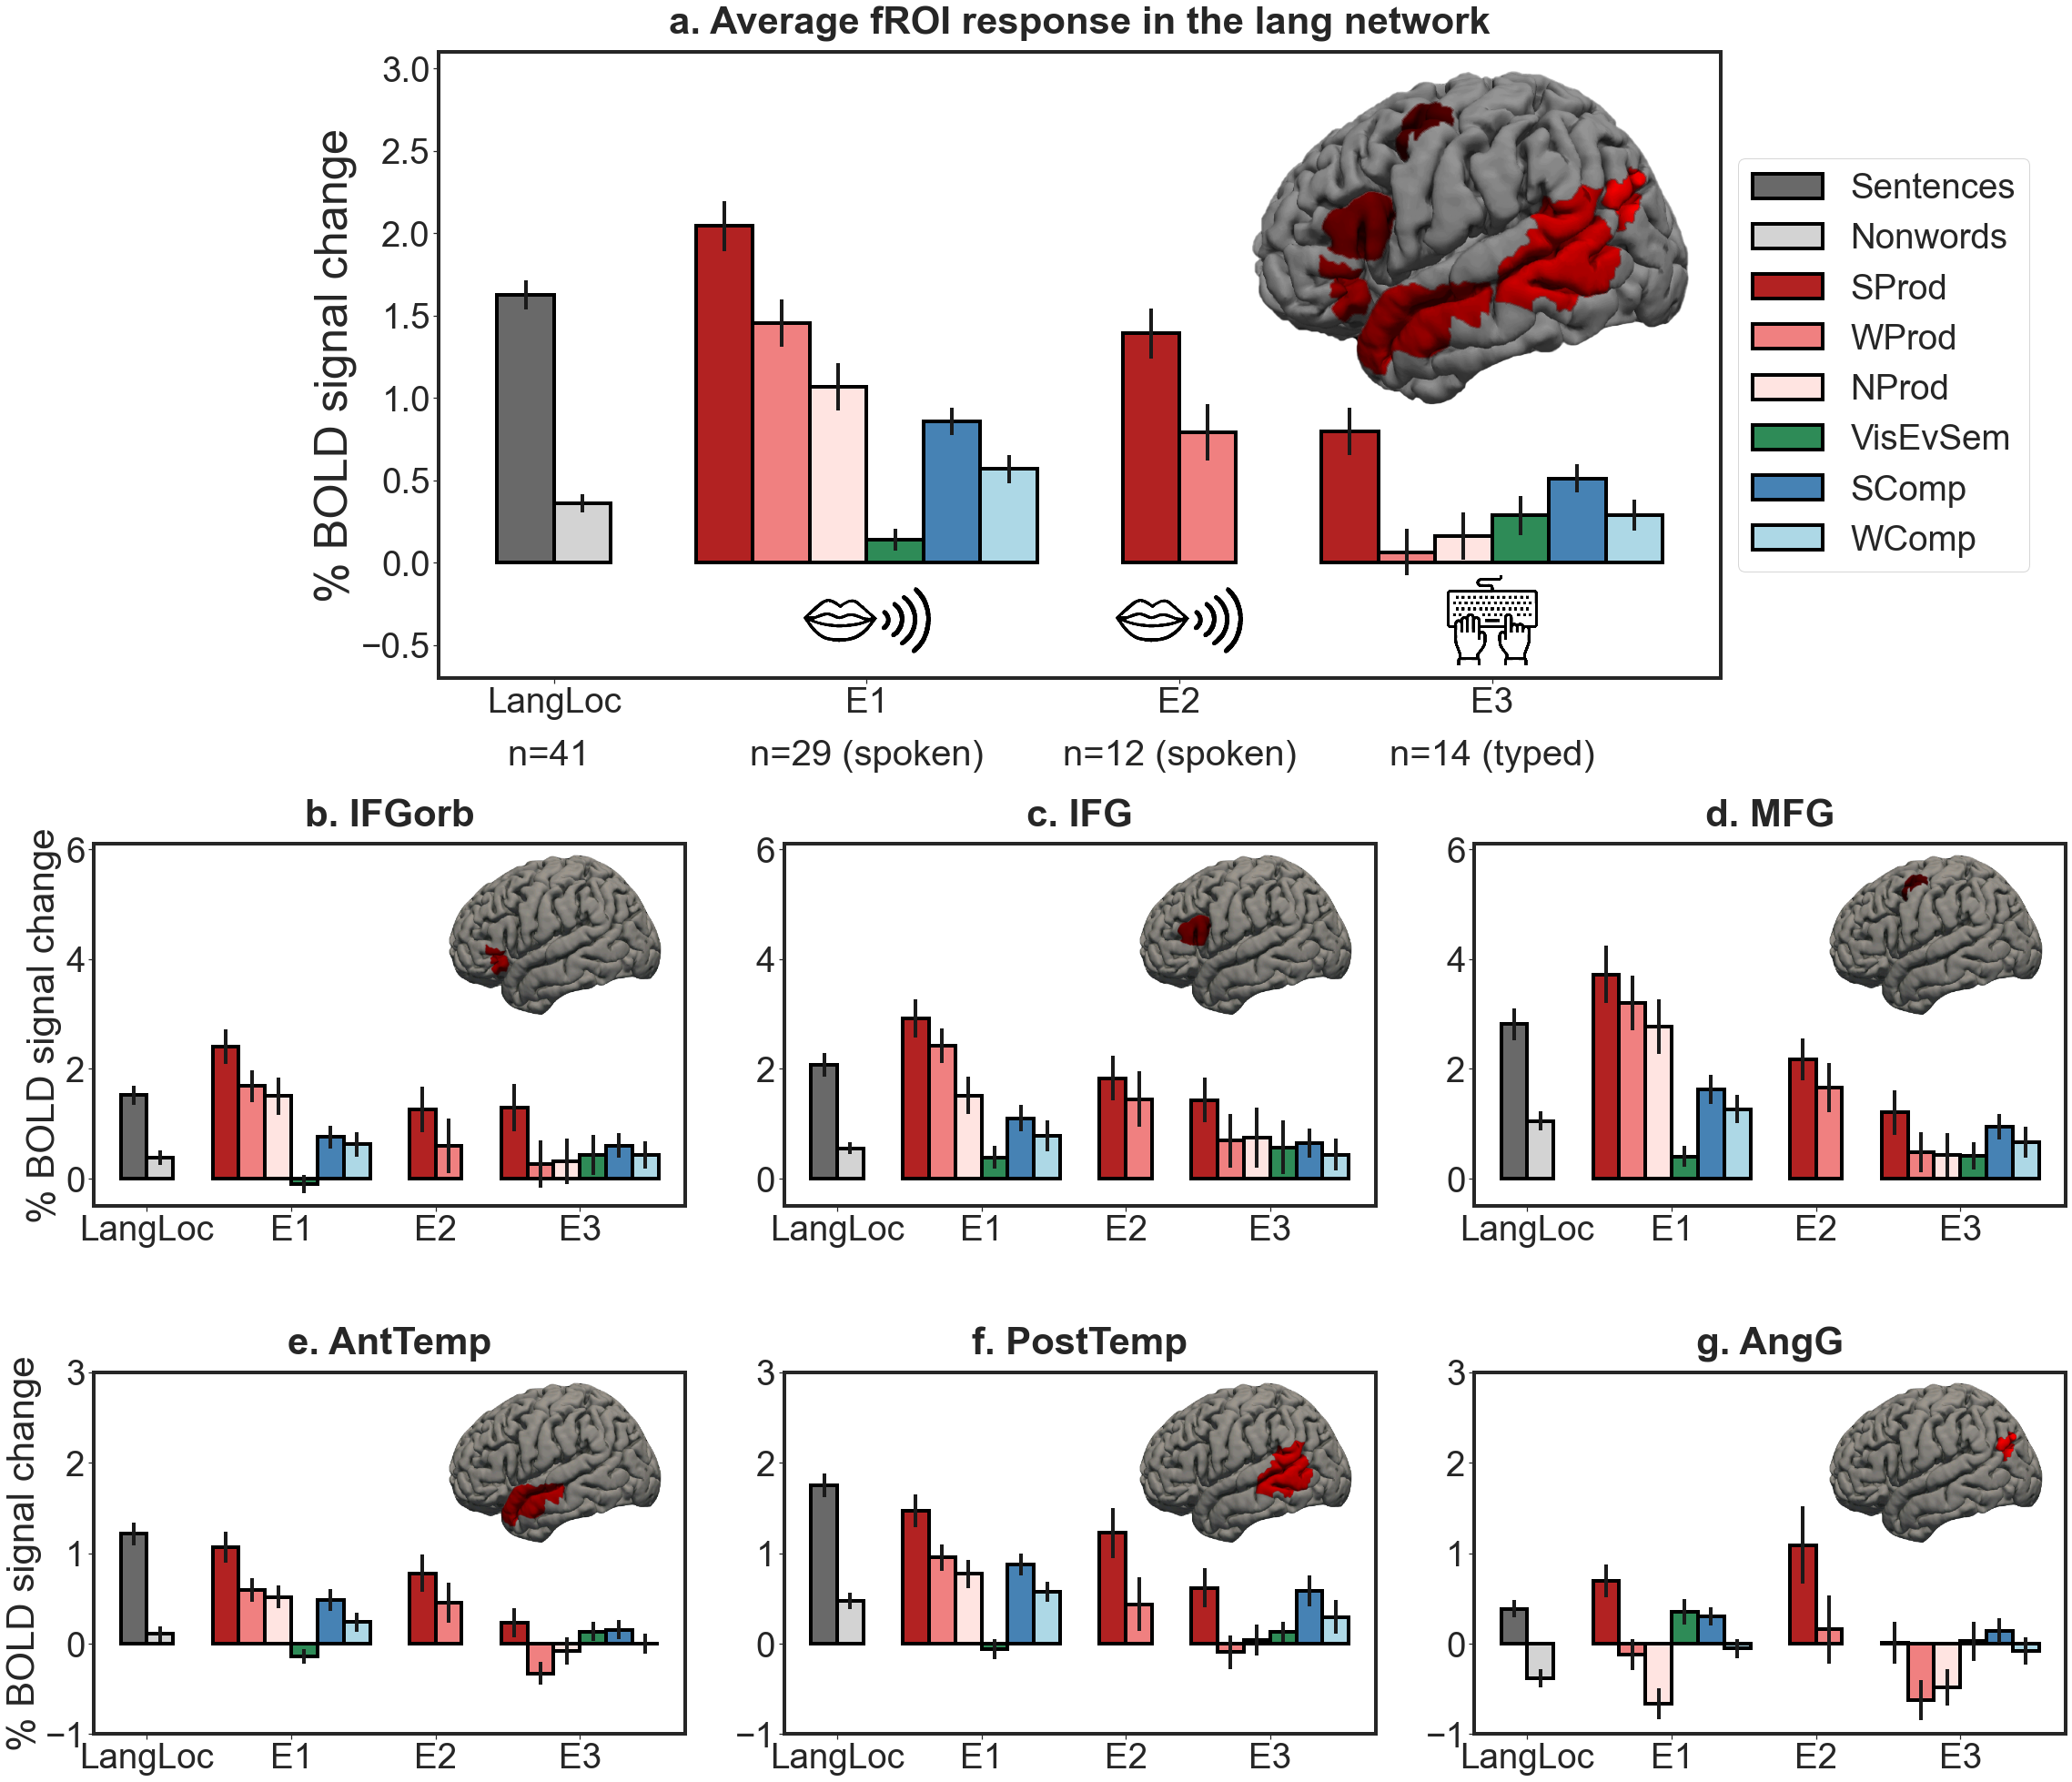

In [31]:
data_title = 'a. Average fROI response in the lang network'
networks = ['lang'] #which network to include in data
hemispheres = ["LH"] #which hemisphere to include in data
ROIs = [i for i in range(1,6+1)]


#read in the csv with all data
#this csv is in long format
all_indiv_data = pd.read_csv('../../data/fMRI_all_indiv_production_data.csv')

experiment_names = ["langloc","E1","E2","E3"]
new_exp_names = ["LangLoc","E1","E2","E3"] #one to one correspondence with above list, replacement names

conditions = {"LangLoc": ["Sentences","Nonwords"],
             "E1": ["SProd","WProd","NProd","VisEvSem","SComp","WComp"],
             "E2": ["SProd","WProd"],
             "E3": ["SProd","WProd","NProd","VisEvSem","SComp","WComp"]}

criticalTasks = ["langloc","ProdLoc_spoken","NameRead","ProdLoc_typed"] #target criticalTasks in the expts
consolidated_expt = "langloc" #expt that has consolidated data across all the experiments

#create layout for the full figure
# lang_fig = plt.figure(figsize=(90,54),constrained_layout=False)
lang_fig = plt.figure(figsize=(70,34),constrained_layout=False)
gs1 = lang_fig.add_gridspec(nrows=7, ncols=6, left=0.05, right=0.48, wspace=0.4, hspace = 1.7)
lang_fig_ax1 = lang_fig.add_subplot(gs1[0:3,1:5])

indiv_data = prep_data(all_indiv_data, consolidated_expt,networks, hemispheres, ROIs, conditions, criticalTasks, experiment_names, new_exp_names)

plot_data(ax=lang_fig_ax1,
         data=indiv_data, 
         data_title=data_title,
         network = 'lang',
         expt_order = new_exp_names,
         conditions = conditions,
         brain_image = "../images/lang_LH.png",
         main_brain = True,
         plot_legend=True,
         plot_labels=True,
         plot_icons=True,
         ylim=(0,3.1))

col_idx= [0,2,4]
row_idx= [3,5]
alphabet_labels = ['b','c','d','e','f','g']
ROIs = 0
for row in row_idx:
    for col in col_idx:
        ROIs= ROIs+1
        if ROIs<=3:
            ylim=(-0.5,6.09)
        else:
            ylim=(-1,3)
        lang_fig_ax = lang_fig.add_subplot(gs1[row:row+2,col:col+2])
        indiv_data = prep_data(all_indiv_data, consolidated_expt,networks, hemispheres, [ROIs], conditions, criticalTasks, experiment_names, new_exp_names)
        #get name of ROI for plotting and to get correct brain image
        ROI_name = "".join(pd.unique(indiv_data.ROI_name))
        data_title=alphabet_labels[ROIs-1]+'. '+ROI_name
        brain_image="../images/lang_L"+ROI_name+".png"
        plot_data(ax=lang_fig_ax,
                 data=indiv_data, 
                 data_title=data_title,
                 network = 'lang',
                 expt_order = new_exp_names,
                 conditions = conditions,
                 brain_image = brain_image,
                 ylabel=(col==0),
                 ylim=ylim)
        
plt.savefig("../figures/figure2_lang_fig.tiff", bbox_inches = 'tight')  
plt.savefig("../figures/figure2_lang_fig.png", bbox_inches = 'tight')  

# Figure 3

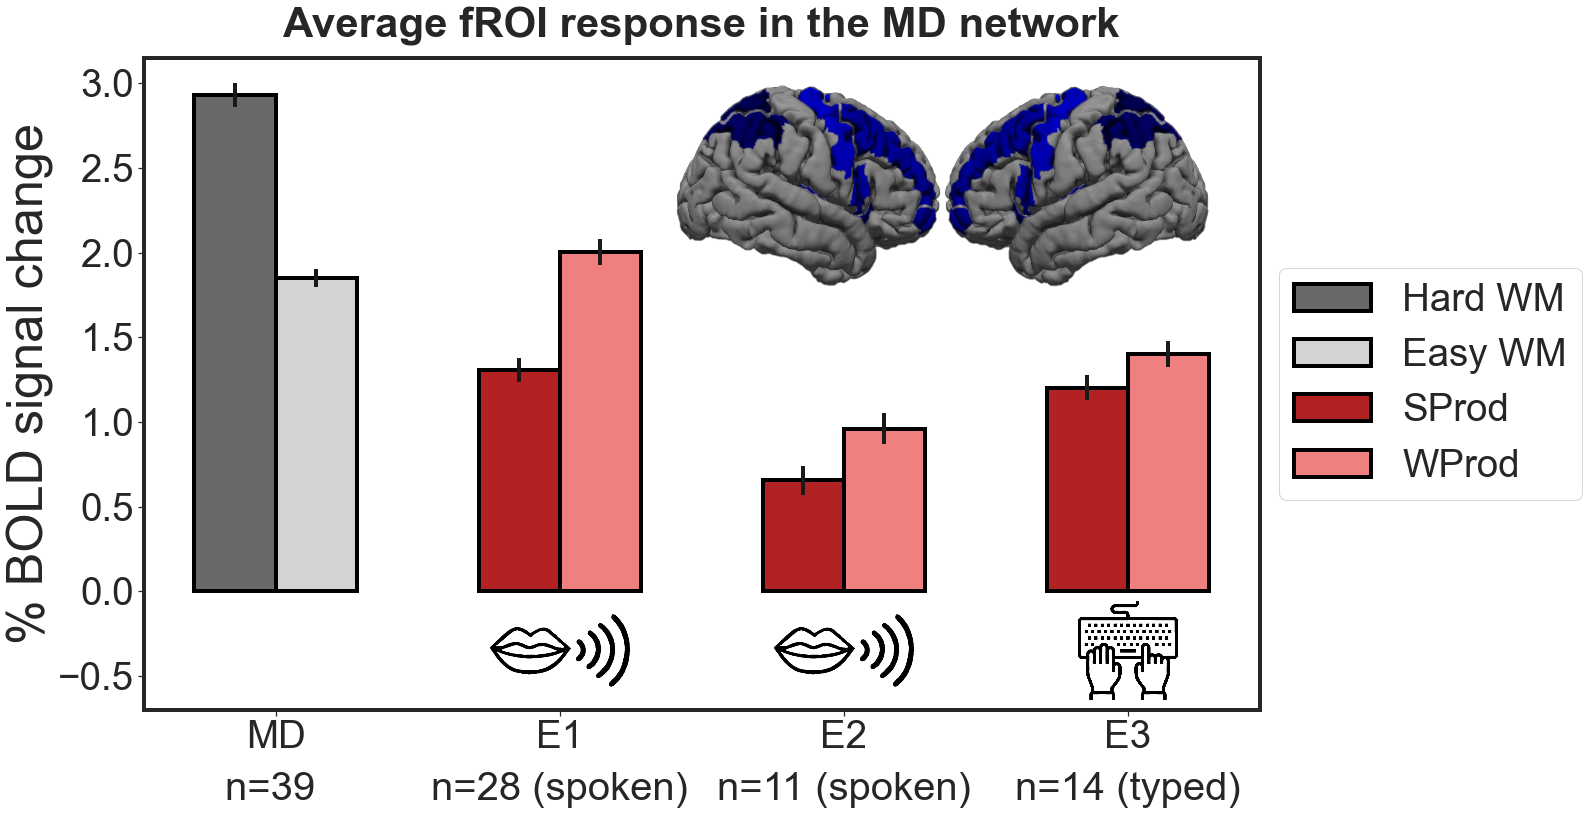

In [32]:
data_title = 'Average fROI response in the MD network'
networks = ['MD'] #which network to include in data
hemispheres = ["LH","RH"] #which hemisphere to include in data
ROIs = [i for i in range(1,20+1)]

conditions = {"MD": ["Hard WM","Easy WM"],
             "E1": ["SProd","WProd"],
             "E2": ["SProd","WProd"],
             "E3": ["SProd","WProd"],
             }

experiment_names = ["MD","E1","E2","E3"]
new_exp_names = ["MD","E1","E2","E3"] #one to one correspondence with above list, replacement names

criticalTasks = ["spWM","ProdLoc_spoken","NameRead","ProdLoc_typed"] #target criticalTasks in the expts
consolidated_expt = "MD" #expt that has consolidated data across all the experiments

#create layout for the full figure
MD_fig = plt.figure(figsize=(20,12),constrained_layout=False)
MD_fig_ax1 = plt.gca()

ylim = (0, 3.6)
indiv_data = prep_data(all_indiv_data, consolidated_expt,networks, hemispheres, ROIs, conditions, criticalTasks, experiment_names, new_exp_names)

plot_data(ax=MD_fig_ax1,
         data=indiv_data, 
         data_title=data_title,
         network = "MD",
         expt_order = new_exp_names,
         conditions = conditions,
         brain_image = "../images/MD_RHLH.png",
         main_brain = True,
         plot_legend=True,
         plot_labels=True,
         plot_icons=True,
         ylim=None)


plt.savefig("../figures/figure3_MD_fig.tiff", bbox_inches = 'tight')
plt.savefig("../figures/figure3_MD_fig.png", bbox_inches = 'tight')

# Figure 4

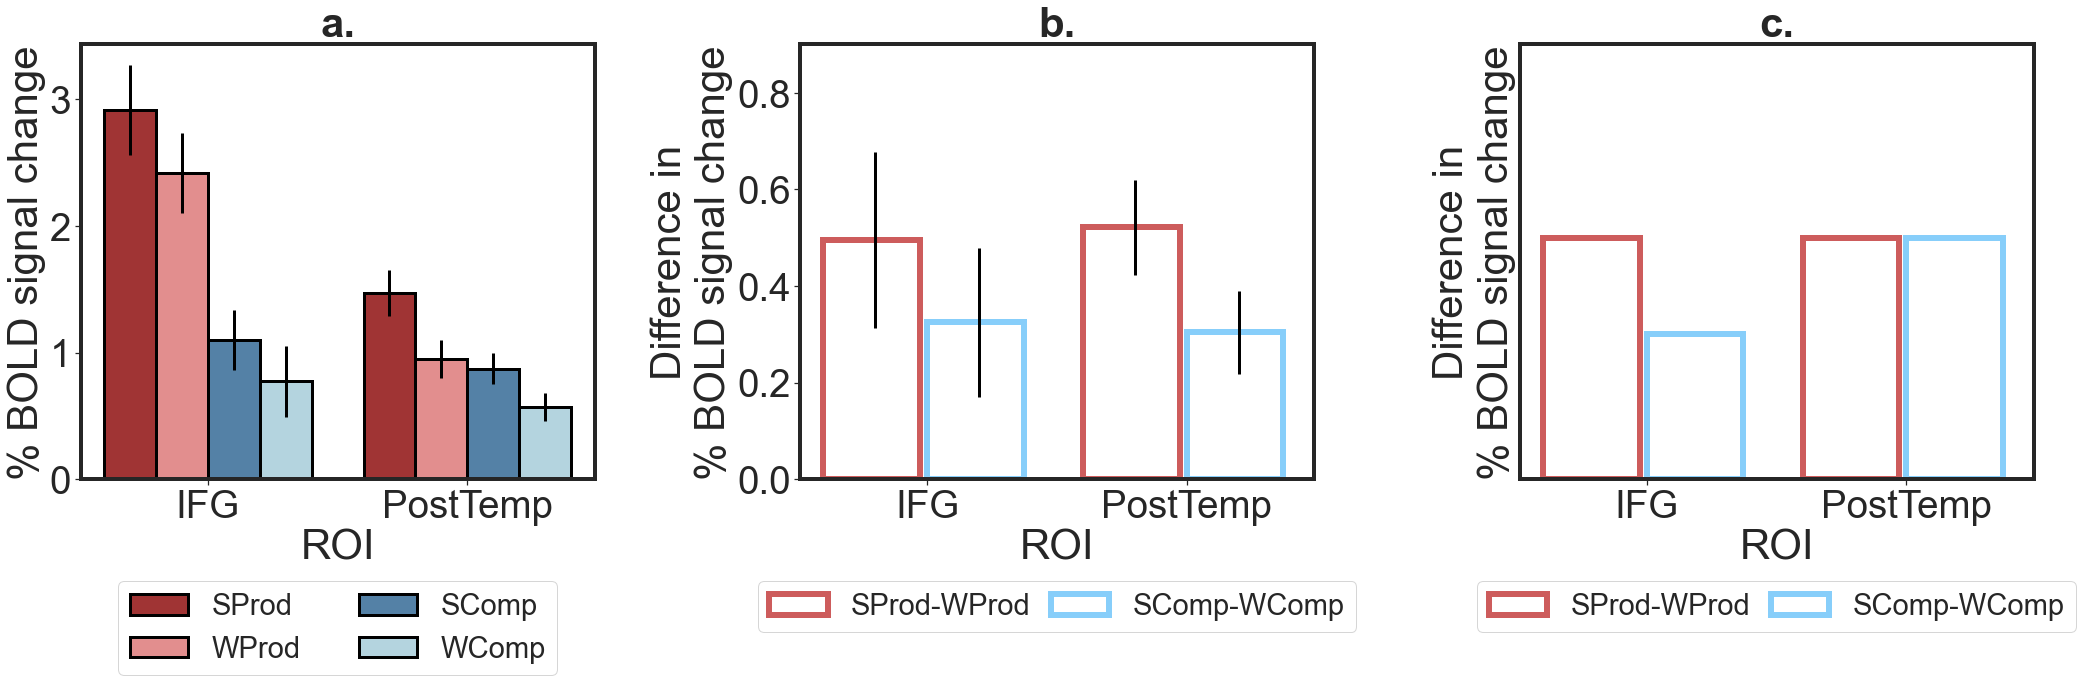

In [19]:
lang_ROI_names = ['IFGorb', 'IFG', 'MFG', 'AntTemp', 'PostTemp', 'AngG']

networks = ['lang'] #which network to include in data
hemispheres = ["LH"] #which hemisphere to include in data
ROI_names = ["IFG", "PostTemp"]
ROIs = [lang_ROI_names.index(roi)+1 for roi in ROI_names]


#read in the csv with all data
#this csv is in long format
all_indiv_data = pd.read_csv('../../data/fMRI_all_indiv_production_data.csv')

experiment_names = ["E1"]
new_exp_names = ["E1"] #one to one correspondence with above list, replacement names

conditions = {"E1": ["SProd","WProd","SComp","WComp"]}

criticalTasks = ["ProdLoc_spoken"] #target criticalTasks in the expts
consolidated_expt = "langloc" #expt that has consolidated data across all the experiments

#create layout for the full figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(35,8))

indiv_data = prep_data(all_indiv_data, consolidated_expt,networks, hemispheres, ROIs, conditions, criticalTasks, experiment_names, new_exp_names)

color_dict = {'SProd':'firebrick',
                 'WProd':'lightcoral',
                 'NProd':'mistyrose',
                 'SComp':'steelblue',
                 'WComp':'lightblue',
                 'VisEvSem':'seagreen',
                 'H':'dimgrey',
                 'E':'lightgrey',
                 'S':'dimgrey',
                 'N':'lightgrey'}

contrast_color_dict = {
    'SProd-WProd': 'indianred',
    'SComp-WComp': 'lightskyblue'
}

TITLE_KWS = dict(fontweight="bold")
BAR_KWS = dict(edgecolor="black", lw=3)
ERR_KWS = dict(color="black", lw=3)

for i, ax in enumerate(axes):
    if i == 0:
        # panel a:
        # a bar graph that shows IFG and PostTemp fROIs with 
        # 4 bars for each (from Expt 1): SProd, WProd, SComp, WComp.
        ax = sns.barplot(
            ax=ax, data=indiv_data, x="ROI_name", y="EffectSize", hue="Effect", 
            palette=color_dict, ci=None, **BAR_KWS
        )
        for bar_idx, bar in enumerate(ax.patches):
            # ERROR BARS
            maps = [
                ("SProd", "IFG"),
                ("SProd", "PostTemp"),
                ("WProd", "IFG"),
                ("WProd", "PostTemp"),
                ("SComp", "IFG"),
                ("SComp", "PostTemp"),
                ("WComp", "IFG"),
                ("WComp", "PostTemp"),
            ]
            cond, roi = maps[bar_idx]
            sem = indiv_data[(indiv_data.Effect==cond)&(indiv_data.ROI_name==roi)].EffectSize.sem()
            x = bar.get_x() + bar.get_width()/2
            y = bar.get_height()
            ax.errorbar(x, y, yerr=sem, **ERR_KWS)
        ax.set_title("a.", **TITLE_KWS)
        ax.set_ylabel("% BOLD signal change")
        ax.legend(
            title="", fontsize="x-small", 
            loc='upper center', bbox_to_anchor=(0.5, -0.2), 
            ncol=2)
        
    else:
        if i == 1:
            # panel b
            # a bar graph that shows the S>W diffs, so a graph with 2 bars for each fROI: 
            # SProd WProd  SComp WComp SComp>WComp
            ax.set_title("b.", **TITLE_KWS)
            data = []
            for j, roi in enumerate(ROI_names):
                for s in indiv_data.Subject.unique():
                    rows = indiv_data[(indiv_data.Subject==s)&(indiv_data.ROI_name==roi)]
                    for suffix in ["Prod", "Comp"]:
                        data.append({
                            "Subject": s,
                            "ROI": ROIs[j],
                            "ROI_name": roi,
                            "EffectSizeDiff": rows[rows.Effect==f"S{suffix}"].squeeze().EffectSize - rows[rows.Effect==f"W{suffix}"].squeeze().EffectSize,
                            "Contrast": f"S{suffix}-W{suffix}"
                        })
        else:
            # panel c
            # a bar graph that shows predictions of Matchin and Hickock’s silly account 
            # for the kind of data shown in b: for the Post Temp, the bars should be similar in magnitude, 
            # and for the IFG the prod bar should be higher
            ax.set_title("c.", **TITLE_KWS)
            # Make fake data to show predictions.
            data = [
                {
                    "ROI_name": "IFG",
                    "EffectSizeDiff": 0.5,
                    "Contrast": "SProd-WProd"
                },
                {
                    "ROI_name": "IFG",
                    "EffectSizeDiff": 0.3,
                    "Contrast": "SComp-WComp"
                },
                {
                    "ROI_name": "PostTemp",
                    "EffectSizeDiff": 0.5,
                    "Contrast": "SProd-WProd"
                },
                {
                    "ROI_name": "PostTemp",
                    "EffectSizeDiff": 0.5,
                    "Contrast": "SComp-WComp"
                }
            ]
            ax.set_yticks([])
            
        data = pd.DataFrame(data)
        
        ax = sns.barplot(
            ax=ax, data=data, x="ROI_name", y="EffectSizeDiff", hue="Contrast", 
            palette=contrast_color_dict, lw=6, ci=None #**BAR_KWS
        )
        ax.set_ylim(0, 0.9)
        ax.set_ylabel("Difference in\n% BOLD signal change")
        for bar_idx, bar in enumerate(ax.patches):
            # OUTLINE COLORS
            if bar_idx == 0 or bar_idx == 1: # corresponding to SProd-WProd
                bar.set_edgecolor(contrast_color_dict["SProd-WProd"])
            else:
                bar.set_edgecolor(contrast_color_dict["SComp-WComp"])
                
            # ERROR BARS
            maps = [
                ("SProd-WProd", "IFG"),
                ("SProd-WProd", "PostTemp"),
                ("SComp-WComp", "IFG"),
                ("SComp-WComp", "PostTemp")
            ]
            contrast, roi = maps[bar_idx]
            sem = data[(data.Contrast==contrast)&(data.ROI_name==roi)].EffectSizeDiff.sem()
            x = bar.get_x() + bar.get_width()/2
            y = bar.get_height()
            ax.errorbar(x, y, yerr=sem, **ERR_KWS)
            
            # OTHER STYLING
            bar.set_facecolor("white")
            bar.set_width(bar.get_width()*0.93)
          
        patches = []
        for contrast, color in contrast_color_dict.items():
            patch = mpatches.Patch(
                color='white', 
                ec=color, 
                lw=6,
                label=contrast)
            patches.append(patch)
        ax.legend(
            handles=patches, fontsize="x-small", 
            loc='upper center', bbox_to_anchor=(0.5, -0.2), 
            ncol=len(contrast_color_dict.keys()),
            columnspacing=0.7
        )
            
    ax.set_xlabel("ROI")
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4)
    
fig.subplots_adjust(wspace=0.4)
plt.savefig("../figures/figure4_IFG_PostTemp.tiff", bbox_inches="tight")
plt.savefig("../figures/figure4_IFG_PostTemp.png", bbox_inches="tight")

# Supplementary figures

## Figure SI 2a

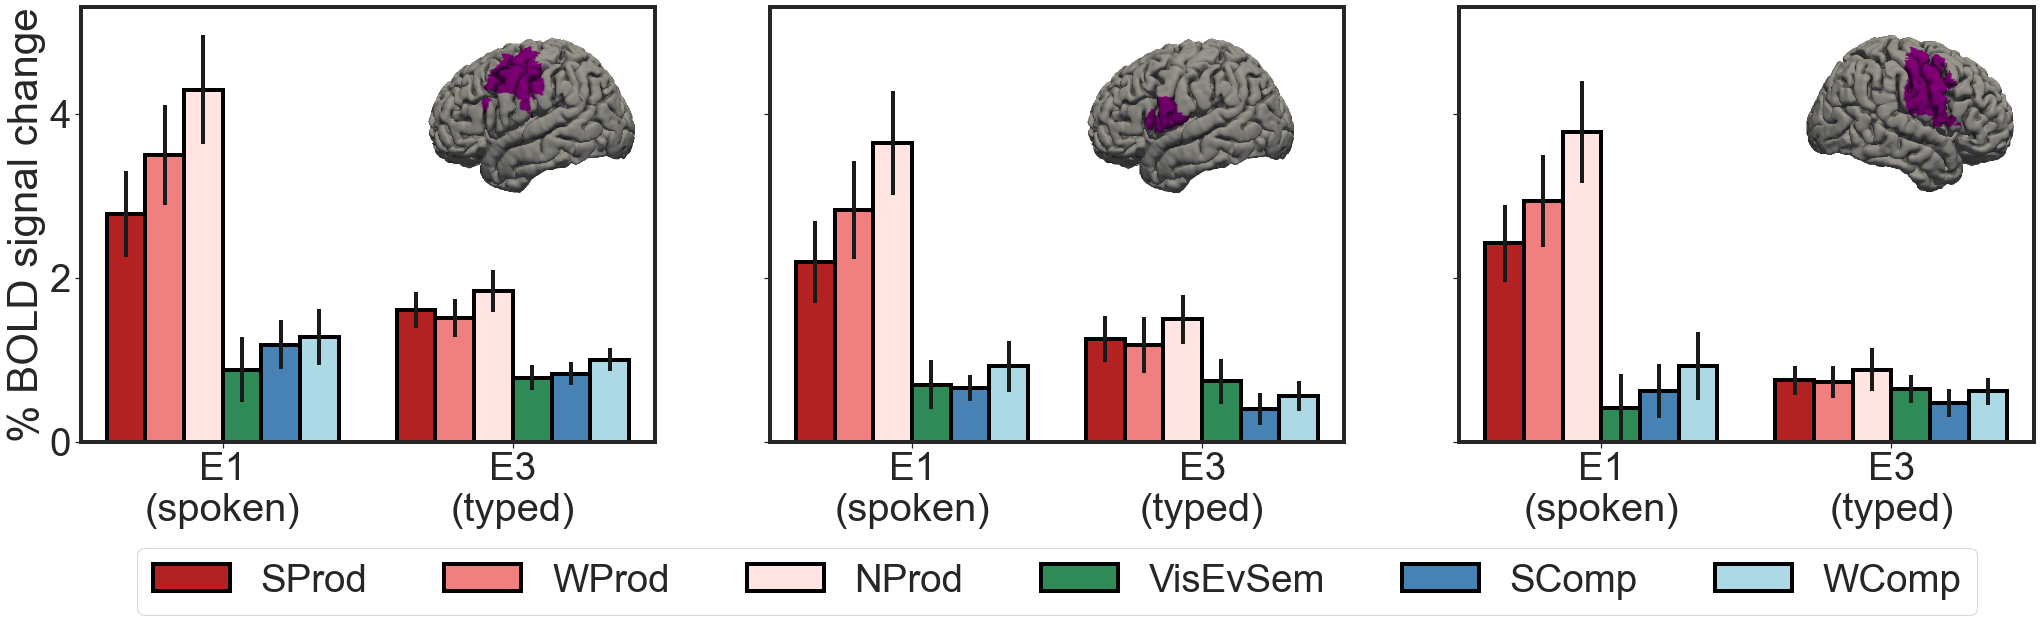

In [37]:
data_title = 'Average fROI response in the low-level speaking regions'
networks = ['lowlevel_speaking'] #which network to include in data
hemispheres = ["LH","RH"] #which hemisphere to include in data
ROIs = [1,3,4]


#read in the csv with all data
# all_indiv_data = pd.read_csv('../../data/fMRI_all_indiv_production_data.csv')

experiment_names = ["E1","E3"]
new_exp_names = ["E1","E3"] #one to one correspondence with above list, replacement names

conditions = {"E1": ["SProd","WProd","NProd","VisEvSem","SComp","WComp"],
             "E3": ["SProd","WProd","NProd","VisEvSem","SComp","WComp"]
             }

criticalTasks = ["ProdLoc_spoken","ProdLoc_typed"] #target criticalTasks in the expts
consolidated_expt = None #expt that has consolidated data across all the experiments

#create layout for the full figure
fig, axes = plt.subplots(nrows=1, ncols=len(ROIs), sharey=True, sharex=True, figsize=(35,8))

ylim = (0,5.3)

for i, ax in enumerate(axes):
    indiv_data = prep_data(all_indiv_data, consolidated_expt,networks, hemispheres, [ROIs[i]], conditions, criticalTasks, experiment_names, new_exp_names)
    #get name of ROI for plotting and to get correct brain image
    ROI_name = "".join(pd.unique(indiv_data.ROI_name))
    brain_image = "../images/lowlevel_speaking_fROI_"+ROI_name+".png"
    ROI_name=""
    ax = plot_data(ax=ax,
             data=indiv_data, 
             data_title=ROI_name,
             network = 'lowlevel_speaking',
             brain_image = brain_image,
             expt_order = new_exp_names,
             conditions = conditions,
             plot_labels = True,
             plot_legend=(i==1), # only plot legend under middle plot
             ylim=ylim)
    if i > 0:
        ax.set_ylabel("")
    
plt.savefig("../figures/figure_si2a_lowlevel_speaking_fig.tiff", bbox_inches = 'tight')  

## Figure SI 2b

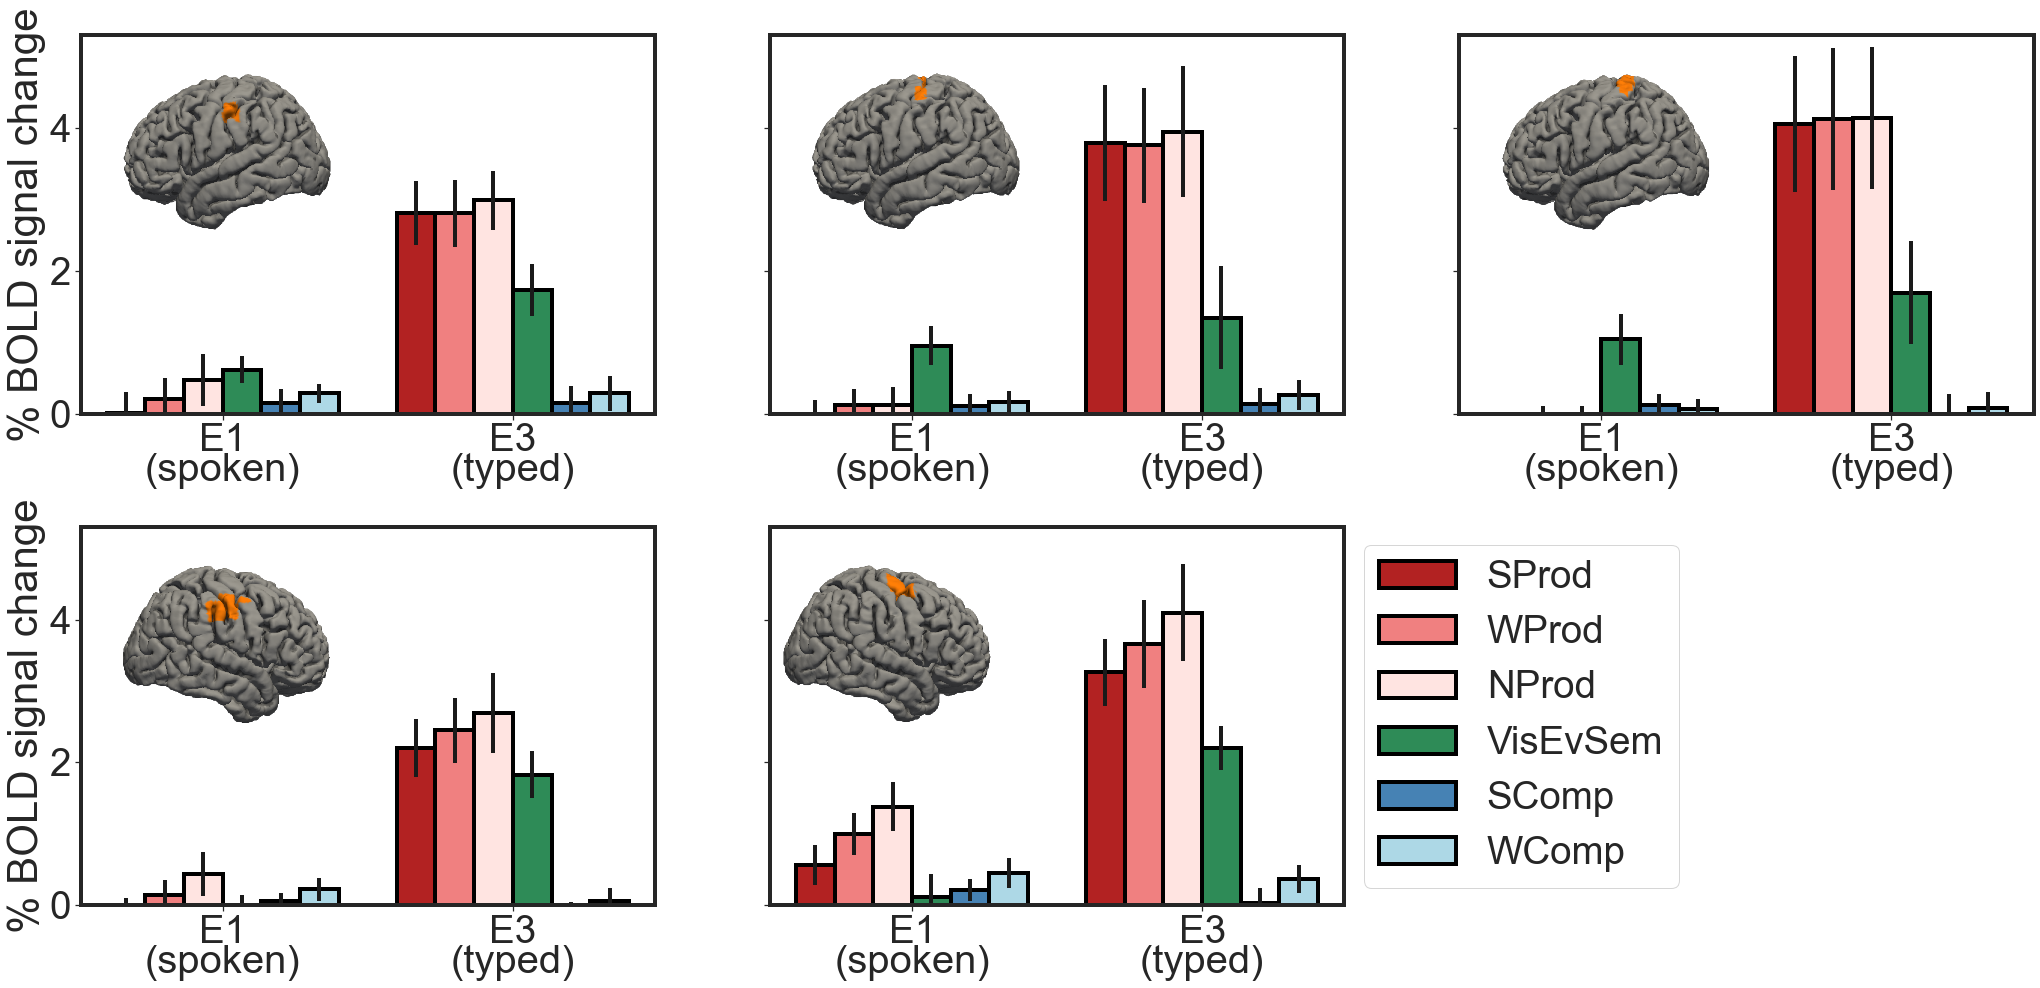

In [59]:
data_title = 'Average fROI response in the low-level typing regions'
networks = ['lowlevel_typing'] #which network to include in data
hemispheres = ["LH","RH"] #which hemisphere to include in data
ROIs = [30,10,23,27,5]


#read in the csv with all data
all_indiv_data = pd.read_csv('../../data/fMRI_all_indiv_production_data.csv')

experiment_names = ["E1","E3"]
new_exp_names = ["E1","E3"] #one to one correspondence with above list, replacement names

conditions = {"E1": ["SProd","WProd","NProd","VisEvSem","SComp","WComp"],
             "E3": ["SProd","WProd","NProd","VisEvSem","SComp","WComp"]
             }

criticalTasks = ["ProdLoc_spoken","ProdLoc_typed"] #target criticalTasks in the expts
consolidated_expt = None #expt that has consolidated data across all the experiments

#create layout for the full figure
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=False, figsize=(35,16))

ylim = (0,5.3)

roi_id = 0
for row_id in range(2):
    for col_id in range(3):
        ax = axes[row_id][col_id]
        # skip the bottom right subplot (leave empty)
        if row_id == 1 and col_id == 2:
            ax.set_visible(False)
        else:
            indiv_data = prep_data(all_indiv_data, consolidated_expt,networks, hemispheres, [ROIs[roi_id]], conditions, criticalTasks, experiment_names, new_exp_names)
            #get name of ROI for plotting and to get correct brain image
            ROI_name = "".join(pd.unique(indiv_data.ROI_name))
            brain_image = "../images/lowlevel_typing_fROI_"+ROI_name+".png"
            ax = plot_data(ax=ax,
                     data=indiv_data, 
                     data_title="",
                     network = 'lowlevel_typing',
                     brain_image = brain_image,
                     expt_order = new_exp_names,
                     conditions = conditions,
                     plot_labels = True,
                     plot_legend=(row_id==1 and col_id==1), # only plot legend next to bottom center plot
                     ylim=ylim)
            if col_id > 0:
                ax.set_ylabel("")
            roi_id += 1
plt.subplots_adjust(hspace=0.3)
    
plt.savefig("../figures/figure_si2b_lowlevel_typing_fig.tiff", bbox_inches = 'tight')  

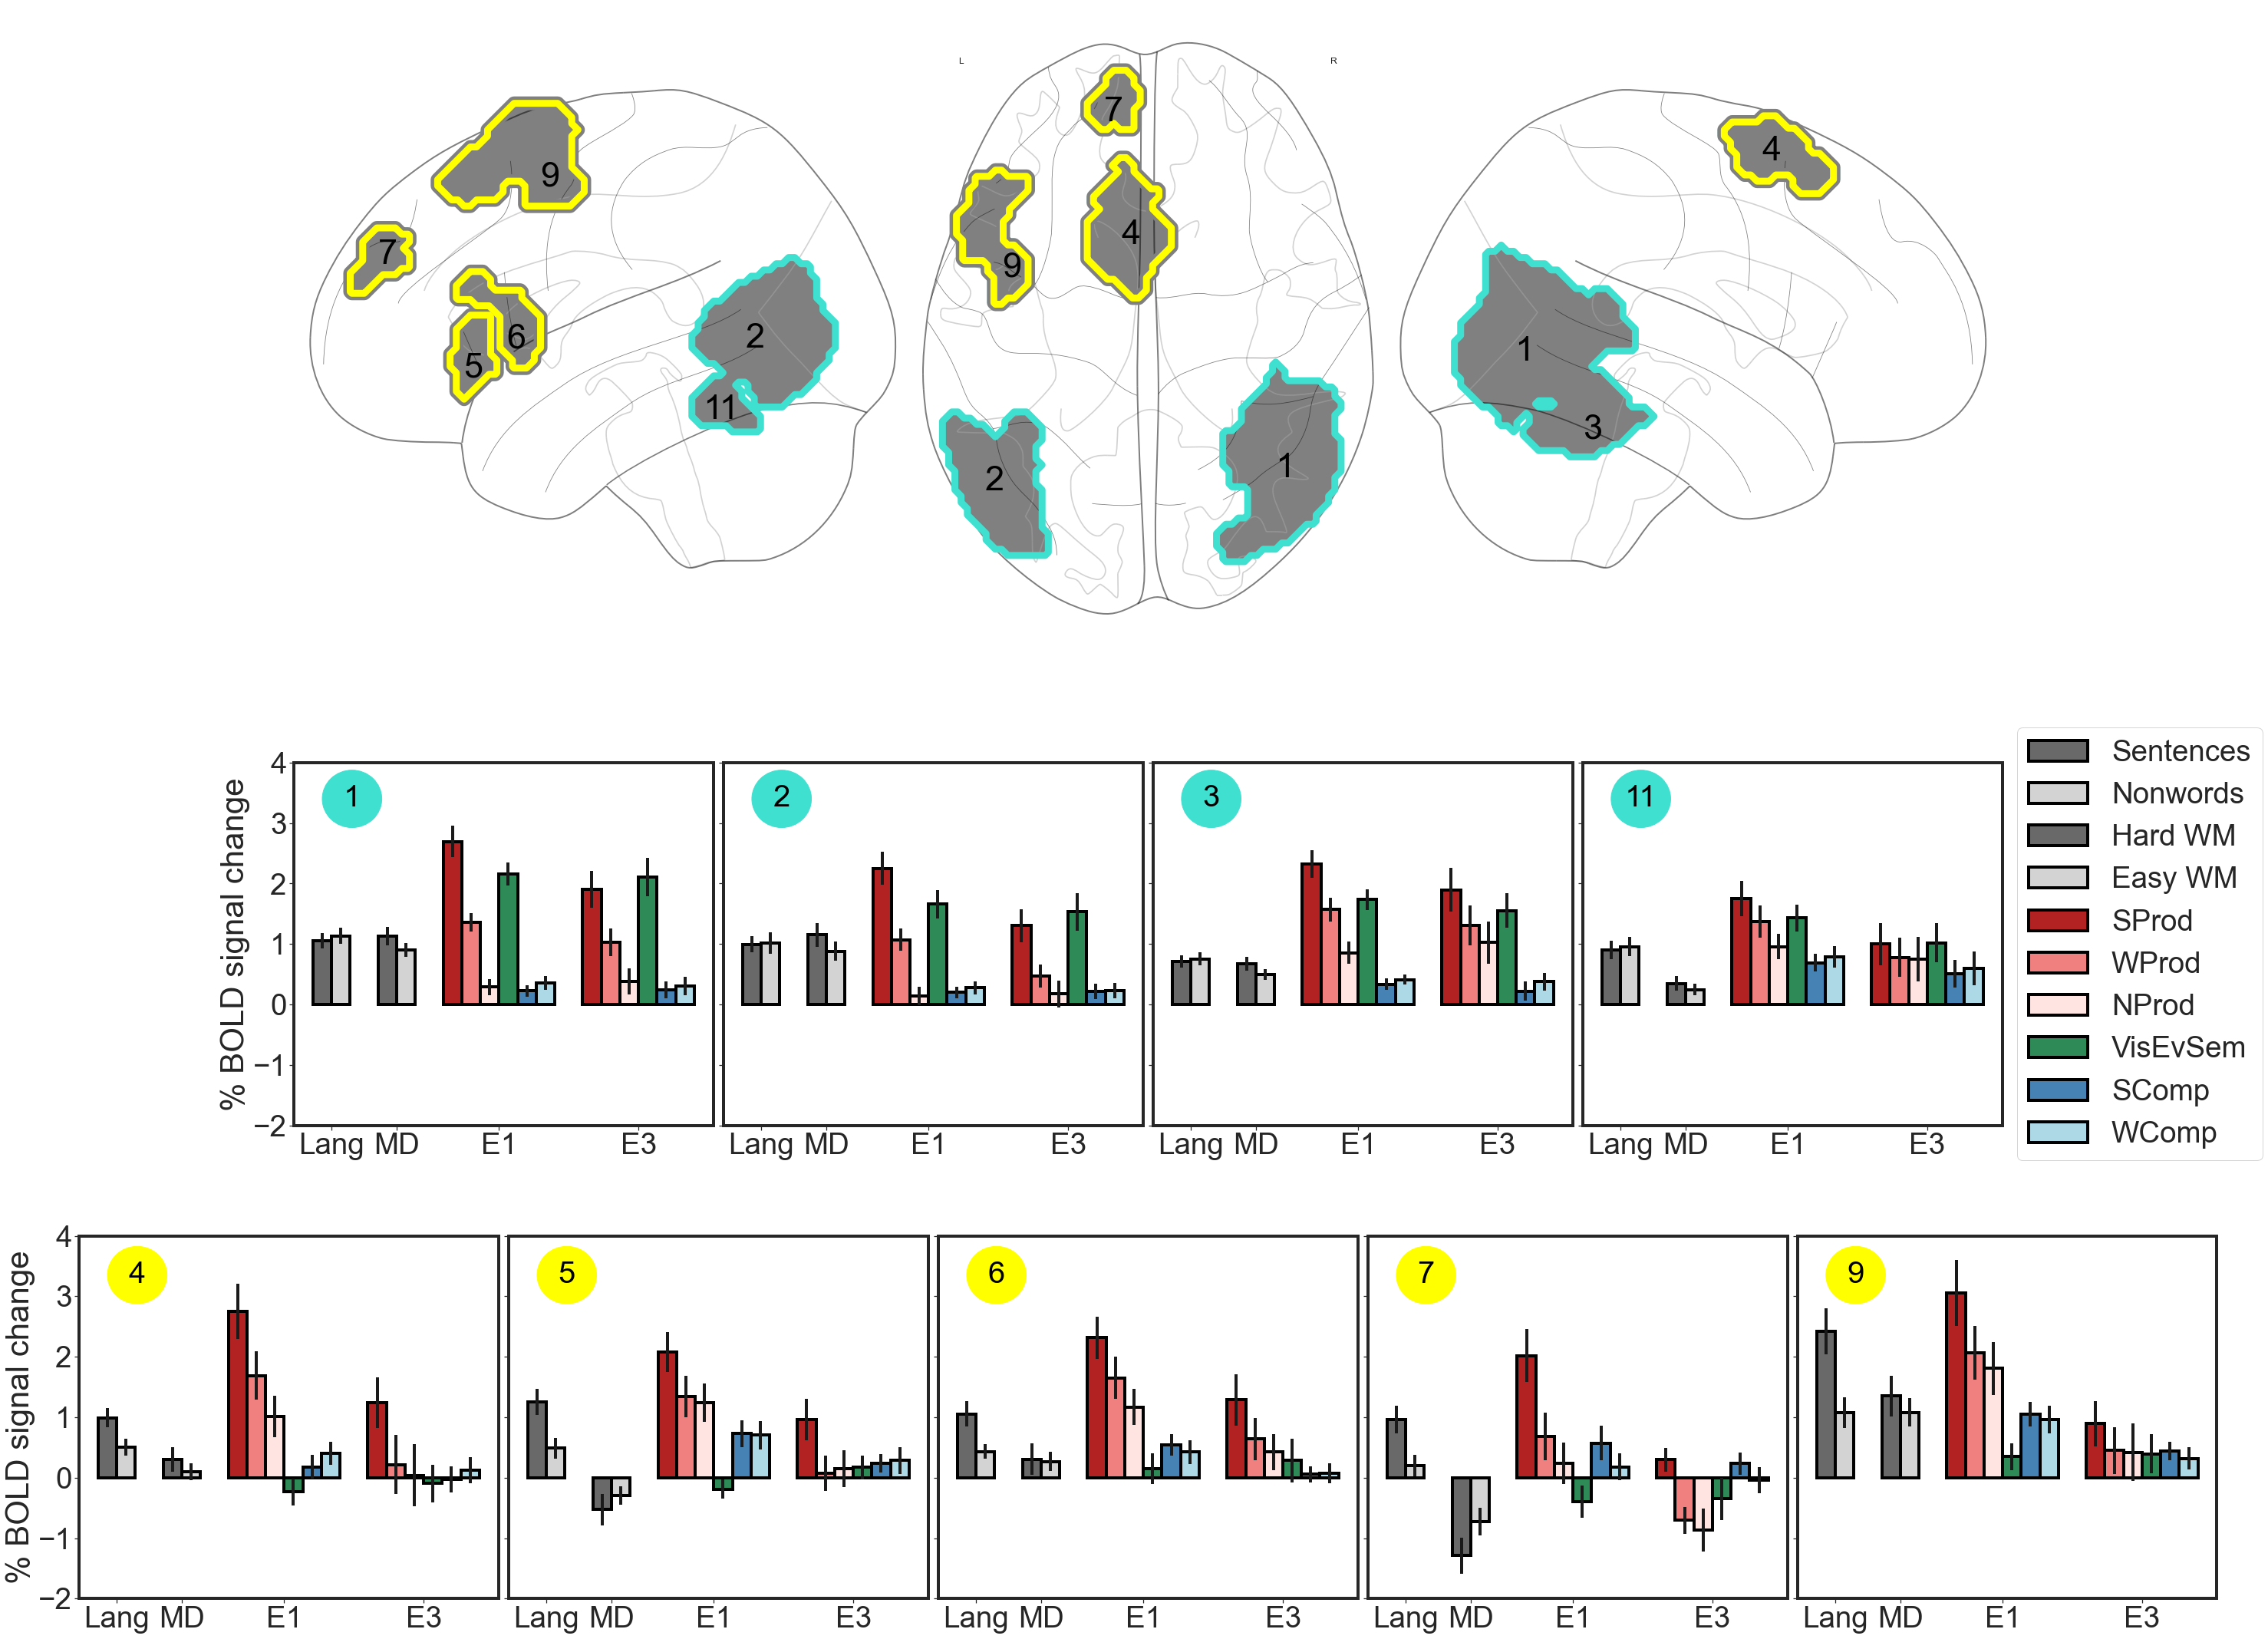

In [42]:
data_title = 'Average fROI response in SProd>SComp AND SProd>WProd regions'
networks = ['production'] #which network to include in data
hemispheres = ["LH","RH"] #which hemisphere to include in data
ROIs = [1,2,3,11,4,5,6,7,9]
plot_labels_bool = [1,0,0,0,1,0,0,0,0]
plot_legend_bool = [0,0,0,1,0,0,0,0,0]

#read in the csv with all data
all_indiv_data = pd.read_csv('../../data/fMRI_all_indiv_production_data.csv')

experiment_names = ["LangLoc","MD","E1","E3"]
new_exp_names = ["Lang","MD","E1","E3"] #one to one correspondence with above list, replacement names

conditions = {"Lang":["Sentences","Nonwords"],
              "MD":["Hard WM","Easy WM"],
              "E1": ["SProd","WProd","NProd","VisEvSem","SComp","WComp"],
              "E3": ["SProd","WProd","NProd","VisEvSem","SComp","WComp"]
             }

criticalTasks = ["langloc","spWM","ProdLoc_spoken","ProdLoc_typed"] #target criticalTasks in the expts
consolidated_expt = None#expt that has consolidated data across all the experiments

#create layout for the full figure
fig = plt.figure(figsize=(90,45),constrained_layout=False)
gs1 = fig.add_gridspec(nrows=20, ncols=10, left=0.05, right=0.48, wspace=0.05)
fig_ax1 = fig.add_subplot(gs1[0:7,1:9])

stat_img = "../parcels/SProd_SCompANDSProd_WProdfROIs.nii"
ROI_color1="turquoise"
ROI_color2="yellow"
img = nib.load(stat_img)
data = img.get_fdata()
#select only the significant fROIs
data_filtered = np.zeros(data.shape)
for ix,i in enumerate(data):
    for jx,j in enumerate(i):
        for kx,k in enumerate(j):
            if((k==1)|(k==2)|(k==3)|(k==11)):
                data_filtered[ix,jx,kx]=1
            if((k==4)|(k==5)|(k==6)|(k==7)|(k==9)):
                data_filtered[ix,jx,kx]=2

affine = img.affine
new_image = nib.Nifti1Image(data_filtered, affine)
new_image_name = '../parcels/selected_production_ROIs.nii'
nib.save(new_image, new_image_name)
colors = plt.cm.get_cmap('gray')
display = plotting.plot_glass_brain(new_image_name,
                                        display_mode='lzr',
                                        threshold=0.5,
                                        cmap=colors,
                                        alpha=0.5,
                                        vmax=10000,
                                        resampling_interpolation='continuous',axes=fig_ax1, figure=fig)
#lining with gray as second color to cover up the turqoise that bleeds into the yellow
display.add_contours(new_image_name, filled=False, levels=[0.5,1.5], colors=[ROI_color1,'gray'],linewidths=[9,18])
display.add_contours(new_image_name, filled=False, levels=[1.5], colors=[ROI_color2],linewidths=9)
fontsize = 45
#right hemisphere
fig_ax1.annotate(text='1',xy=(.72,.44), xycoords=('axes fraction','axes fraction'),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize,color="black",zorder=100,annotation_clip=False)
fig_ax1.annotate(text='3',xy=(.76,.32), xycoords=('axes fraction','axes fraction'),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize,color="black",zorder=100,annotation_clip=False)
fig_ax1.annotate(text='4',xy=(.865,.75), xycoords=('axes fraction','axes fraction'),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize,color="black",zorder=100,annotation_clip=False)

#left hemisphere
fig_ax1.annotate(text='2',xy=(.27,.46), xycoords=('axes fraction','axes fraction'),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize,color="black",zorder=100,annotation_clip=False)
fig_ax1.annotate(text='11',xy=(.25,.35), xycoords=('axes fraction','axes fraction'),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize,color="black",zorder=100,annotation_clip=False)
fig_ax1.annotate(text='6',xy=(.13,.46), xycoords=('axes fraction','axes fraction'),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize,color="black",zorder=100,annotation_clip=False)
fig_ax1.annotate(text='5',xy=(.105,.415), xycoords=('axes fraction','axes fraction'),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize,color="black",zorder=100,annotation_clip=False)
fig_ax1.annotate(text='9',xy=(.15,.71), xycoords=('axes fraction','axes fraction'),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize,color="black",zorder=100,annotation_clip=False)
fig_ax1.annotate(text='7',xy=(.055,.59), xycoords=('axes fraction','axes fraction'),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize,color="black",zorder=100,annotation_clip=False)


#middle brain
fig_ax1.annotate(text='2',xy=(.41,.24), xycoords=('axes fraction','axes fraction'),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize,color="black",zorder=100,annotation_clip=False)
fig_ax1.annotate(text='1',xy=(.58,.26), xycoords=('axes fraction','axes fraction'),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize,color="black",zorder=100,annotation_clip=False)

fig_ax1.annotate(text='4',xy=(.49,.62), xycoords=('axes fraction','axes fraction'),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize,color="black",zorder=100,annotation_clip=False)
fig_ax1.annotate(text='7',xy=(.48,.81), xycoords=('axes fraction','axes fraction'),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize,color="black",zorder=100,annotation_clip=False)
fig_ax1.annotate(text='9',xy=(.42,.57), xycoords=('axes fraction','axes fraction'),
                    horizontalalignment='center', verticalalignment='bottom', fontsize=fontsize,color="black",zorder=100,annotation_clip=False)



col_idx= [1,3,5,7,9]
row_idx= [8,13]

ylim = (-2,4)

ROI_idx = 0
for row in row_idx:
    for col in col_idx:
        if(ROI_idx<len(ROIs)):
            if(ROI_idx==4):
                row = row + 5
                col = 0
            if(ROI_idx>4):
                col = col+1
            fig_ax = fig.add_subplot(gs1[row:row+4,col:col+2])
            indiv_data = prep_data(all_indiv_data, consolidated_expt,networks, hemispheres, [ROIs[ROI_idx]], conditions, criticalTasks, experiment_names, new_exp_names)
            #get name of ROI for plotting and to get correct brain image
            #print(indiv_data)
            ROI_name = ""#.join(pd.unique(indiv_data.ROI_name))
            brain_image = ""#"../images/lowlevel_speaking_fROI_"+ROI_name+".png"
            #hemi = "".join(pd.unique(indiv_data.Hemisphere))
            #ROI_name = ROI_name+ " ("+hemi+")"
            ax = plot_data(ax=fig_ax,
                     data=indiv_data, 
                     data_title=ROI_name,
                     network = 'production',
                     brain_image = brain_image,
                     expt_order = new_exp_names,
                     conditions = conditions,
                     plot_labels = False,
                     plot_legend=plot_legend_bool[ROI_idx],
                     ylim=ylim)
            if col > 1:
                ax.set(ylabel="",yticklabels="")
            x = 0.05
            y = 3.4
            if(ROI_idx>3):
                x = 0.05
                y = 3.35
                width = 0.1
                ax.add_artist(Ellipse((x,y), width, 9.5*width, color=ROI_color2))
                ax.annotate(text=ROIs[ROI_idx],xy=(x,y), xycoords=('data','data'),
                    horizontalalignment='center', verticalalignment='center', fontsize=40,color="black",zorder=100,annotation_clip=False)
            else:
                width = 0.1
                ax.add_artist(Ellipse((x,y), width, 9.5*width, color=ROI_color1))
                ax.annotate(text=ROIs[ROI_idx],xy=(x,y), xycoords=('data','data'),
                    horizontalalignment='center', verticalalignment='center', fontsize=40,color="black",zorder=100,annotation_clip=False)
        ROI_idx += 1
    
plt.savefig("../figures/figure_si3_production_fig.tiff", bbox_inches = 'tight')  